In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from pathlib import Path
import sys


In [2]:
BASE_DIR = str(Path().cwd().parent.resolve())
sys.path.insert(0, BASE_DIR)

In [3]:
df = pd.read_csv(f'{BASE_DIR}/data/fake_job_postings.csv', engine = 'python')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [43]:
textdf = df.iloc[:, [1,5,6,7,8,17]]
textdf = textdf.fillna('None')
textdf.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [5]:
def clean_text(text):
    text = text.replace(r'&amp;', '&')
    text = text.replace(r'&nbsp;', ' ')
    text = text.replace(r'&lt;', '<')
    text = text.replace(r'&gt;', '>')
    text = text.replace(r'&quot;', '"')
    text = text.replace(r'\u00a0', ' ')
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
text_cleaned = textdf.copy(deep = True)

for col in text_cleaned.columns[:-1]:
    text_cleaned[col] = text_cleaned[col].astype(str).apply(lambda x : clean_text(x))
    
text_cleaned.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,marketing intern,were and weve created a groundbreaking and aw...,a fastgrowing james beard awardwinning online...,experience with content management systems a m...,none,0
1,customer service cloud video production,seconds the worlds cloud video production se...,organised focused vibrant awesomedo you hav...,what we expect from youyour key responsibility...,what you will get from usthrough being part of...,0
2,commissioning machinery assistant cma,valor services provides workforce solutions th...,our client located in houston is actively seek...,implement precommissioning and commissioning p...,none,0
3,account executive washington dc,our passion for improving quality of life thro...,the company esri – environmental systems resea...,education bachelor’s or master’s in gis busine...,our culture is anything but corporate—we have ...,0
4,bill review manager,spotsource solutions llc is a global human cap...,job title itemization review managerlocation f...,qualificationsrn license in the state of texas...,full benefits offered,0


In [27]:
text_tokenized = text_cleaned.copy(deep = True)

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

for col in text_tokenized.columns[:-1]:
    text_tokenized[col] = text_tokenized[col].apply(lambda x : tokenizer.tokenize(x))

text_tokenized.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,"[marketing, intern]","[were, and, weve, created, a, groundbreaking, ...","[a, fastgrowing, james, beard, awardwinning, o...","[experience, with, content, management, system...",[none],0
1,"[customer, service, cloud, video, production]","[seconds, the, worlds, cloud, video, productio...","[organised, focused, vibrant, awesomedo, you, ...","[what, we, expect, from, youyour, key, respons...","[what, you, will, get, from, usthrough, being,...",0
2,"[commissioning, machinery, assistant, cma]","[valor, services, provides, workforce, solutio...","[our, client, located, in, houston, is, active...","[implement, precommissioning, and, commissioni...",[none],0
3,"[account, executive, washington, dc]","[our, passion, for, improving, quality, of, li...","[the, company, esri, environmental, systems, r...","[education, bachelor, s, or, master, s, in, gi...","[our, culture, is, anything, but, corporate, w...",0
4,"[bill, review, manager]","[spotsource, solutions, llc, is, a, global, hu...","[job, title, itemization, review, managerlocat...","[qualificationsrn, license, in, the, state, of...","[full, benefits, offered]",0


In [28]:
text_stemmed = text_tokenized.copy(deep = True)

stop_words = stopwords.words('english')
ps = PorterStemmer()

for col in text_stemmed.columns[:-1]:
    text_stemmed[col] = text_stemmed[col].apply(lambda x : [ps.stem(w) for w in x if w not in stop_words])
    
text_stemmed.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,"[market, intern]","[weve, creat, groundbreak, awardwin, cook, sit...","[fastgrow, jame, beard, awardwin, onlin, food,...","[experi, content, manag, system, major, plu, b...",[none],0
1,"[custom, servic, cloud, video, product]","[second, world, cloud, video, product, second,...","[organis, focus, vibrant, awesomedo, passion, ...","[expect, youyour, key, respons, commun, client...","[get, usthrough, part, second, team, gainexper...",0
2,"[commiss, machineri, assist, cma]","[valor, servic, provid, workforc, solut, meet,...","[client, locat, houston, activ, seek, experien...","[implement, precommiss, commiss, procedur, rot...",[none],0
3,"[account, execut, washington, dc]","[passion, improv, qualiti, life, geographi, he...","[compani, esri, environment, system, research,...","[educ, bachelor, master, gi, busi, administr, ...","[cultur, anyth, corpor, collabor, creativ, env...",0
4,"[bill, review, manag]","[spotsourc, solut, llc, global, human, capit, ...","[job, titl, item, review, managerloc, fort, wo...","[qualificationsrn, licens, state, texasdiploma...","[full, benefit, offer]",0


In [31]:
text_lemmatized = text_stemmed.copy(deep = True)

wl = WordNetLemmatizer()

for col in text_lemmatized.columns[:-1]:
    text_lemmatized[col] = text_lemmatized[col].apply(lambda x : [wl.lemmatize(w) for w in x])

text_lemmatized.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,"[market, intern]","[weve, creat, groundbreak, awardwin, cook, sit...","[fastgrow, jame, beard, awardwin, onlin, food,...","[experi, content, manag, system, major, plu, b...",[none],0
1,"[custom, servic, cloud, video, product]","[second, world, cloud, video, product, second,...","[organis, focus, vibrant, awesomedo, passion, ...","[expect, youyour, key, respons, commun, client...","[get, usthrough, part, second, team, gainexper...",0
2,"[commiss, machineri, assist, cma]","[valor, servic, provid, workforc, solut, meet,...","[client, locat, houston, activ, seek, experien...","[implement, precommiss, commiss, procedur, rot...",[none],0
3,"[account, execut, washington, dc]","[passion, improv, qualiti, life, geographi, he...","[compani, esri, environment, system, research,...","[educ, bachelor, master, gi, busi, administr, ...","[cultur, anyth, corpor, collabor, creativ, env...",0
4,"[bill, review, manag]","[spotsourc, solut, llc, global, human, capit, ...","[job, titl, item, review, managerloc, fort, wo...","[qualificationsrn, licens, state, texasdiploma...","[full, benefit, offer]",0


In [32]:
text_df = text_lemmatized.copy(deep = True)

for col in text_df.columns[:-1]:
    text_df[col] = text_df[col].apply(lambda x : ' '.join(x))
    
text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,market intern,weve creat groundbreak awardwin cook site supp...,fastgrow jame beard awardwin onlin food commun...,experi content manag system major plu blog cou...,none,0
1,custom servic cloud video product,second world cloud video product second world ...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...,0
2,commiss machineri assist cma,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,none,0
3,account execut washington dc,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educ bachelor master gi busi administr relat f...,cultur anyth corpor collabor creativ environ p...,0
4,bill review manag,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer,0


In [33]:
def get_top_tweet_Ngrams(corpus, size, n=None):
    vec = CountVectorizer(ngram_range=(size, size)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def top_common_tweet(col, size, n):
    top_ngrams_Real = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 0], size)[:n]
    top_ngrams_Fake = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 1], size)[:n]

    words_R, counts_R = map(list, zip(*top_ngrams_Real))
    words_F, counts_F = map(list, zip(*top_ngrams_Fake))

    return list(set(words_R).intersection(words_F))

def top_diff_tweet(col, size, n, REAL = True):
    top_ngrams_Real = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 0], size)[:n]
    top_ngrams_Fake = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 1], size)[:n]

    words_R, counts_R = map(list, zip(*top_ngrams_Real))
    words_F, counts_F = map(list, zip(*top_ngrams_Fake))
    
    if REAL:
        comp = list(set(words_R) - set(words_F))
    else:
        comp = list(set(words_F) - set(words_R))
    
    return comp

In [34]:
Nsize = 2
topk = 20

for col in text_df.columns[:-1]:
    print('top {} {}-grams in {} only in Real'.format(topk, Nsize, col))
    print(top_diff_tweet(col, Nsize, topk, True))

top 20 2-grams in title only in Real
['na year', 'busi develop', 'softwar engin', 'market manag', 'graduat english', 'teacher abroad', 'apprenticeship na', 'abroad convers', 'year old', 'servic associ', 'project manag', 'product manag', 'sale repres', 'web develop', 'account execut', 'account manag', 'english teacher', 'sale manag']
top 20 2-grams in company_profile only in Real
['around world', 'safe secur', 'help compani', 'document commun', 'new york', 'teacher get', 'secur job', 'solut help', 'help teacher', 'qualiti candid', 'medium larg', 'job abroad', 'busi process', 'increas product', 'get safe', 'manag servic', 'custom satisfact', 'high qualiti', 'full time', 'provid full']
top 20 2-grams in description only in Real
['busi develop', 'kid get', 'year experi', 'work close', 'develop team', 'right candid', 'social medium', 'play kid', 'get paid', 'join team', 'student loanscredit', 'monthli cost', 'account manag', 'level custom', 'ideal candid']
top 20 2-grams in requirements onl

In [35]:
Nsize = 2
topk = 20

for col in text_df.columns[:-1]:
    print('top {} {}-grams in {} only in Fake'.format(topk, Nsize, col))
    print(top_diff_tweet(col, Nsize, topk, False))

top 20 2-grams in title only in Fake
['administr assist', 'entri admincler', 'posit work', 'entri clerk', 'work home', 'earn daili', 'clerk posit', 'admincler posit', 'posit earn', 'payrol typistdata', 'data entri', 'cruis staff', 'base payrol', 'payrol data', 'servic repres', 'home base', 'want urgent', 'staff want']
top 20 2-grams in company_profile only in Fake
['referr bonu', 'streamlin hire', 'sign bonu', 'servic town', 'bonu program', 'staf solut', 'hire process', 'aptitud staf', 'candid encourag', 'compens packag', 'particip referr', 'year access', 'real estat', 'partner effort', 'effort streamlin', 'small medium', 'refin resourc', 'encourag particip', 'candid enjoy', 'employe receiv']
top 20 2-grams in description only in Fake
['product system', 'solut global', 'system servic', 'work home', 'servic oil', 'global provid', 'ga industri', 'aker solut', 'data entri', 'oil ga', 'provid product', 'full time', 'industri engin', 'ultra luxuri', 'engin design']
top 20 2-grams in require

In [36]:
def plot_top_Ngrams(col, size, Real = True, n = 20):
    
    if Real:
        top_ngrams = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 0], size)[:n]
    else:
        top_ngrams = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 1], size)[:n]
    
    words, counts = map(list, zip(*top_ngrams))
    
    fig = plt.figure(figsize = (10, n))
    sns.barplot(x = counts, y = words)
    plt.title('top {}-grams of {} in {}'.format(size, col, 'Real' if Real else 'Fake'))
    plt.show()

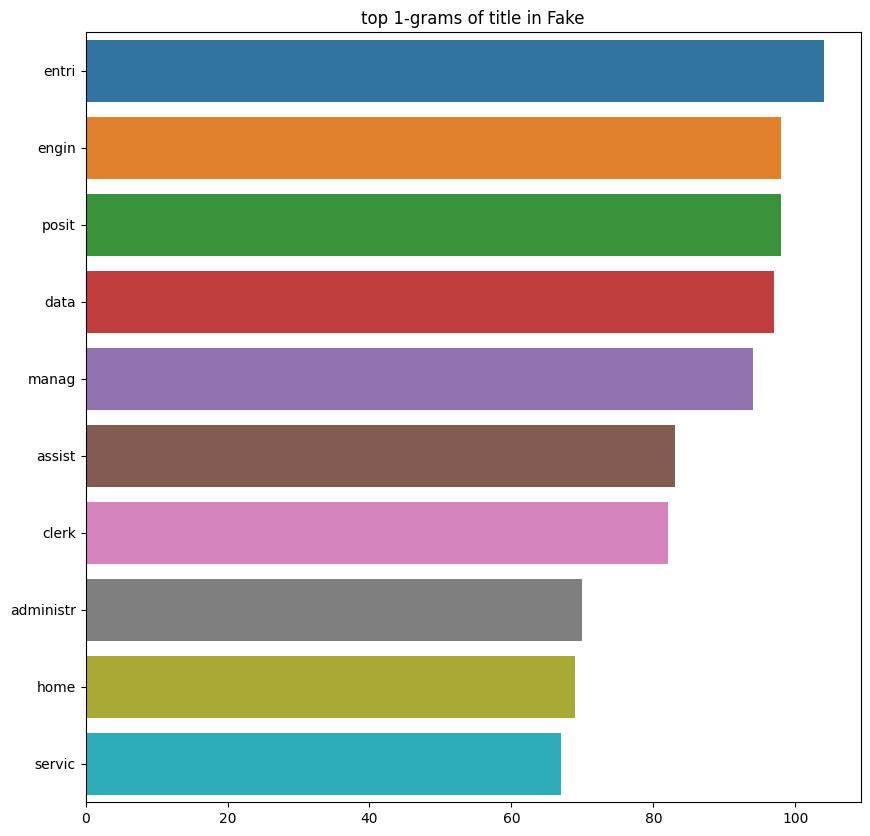

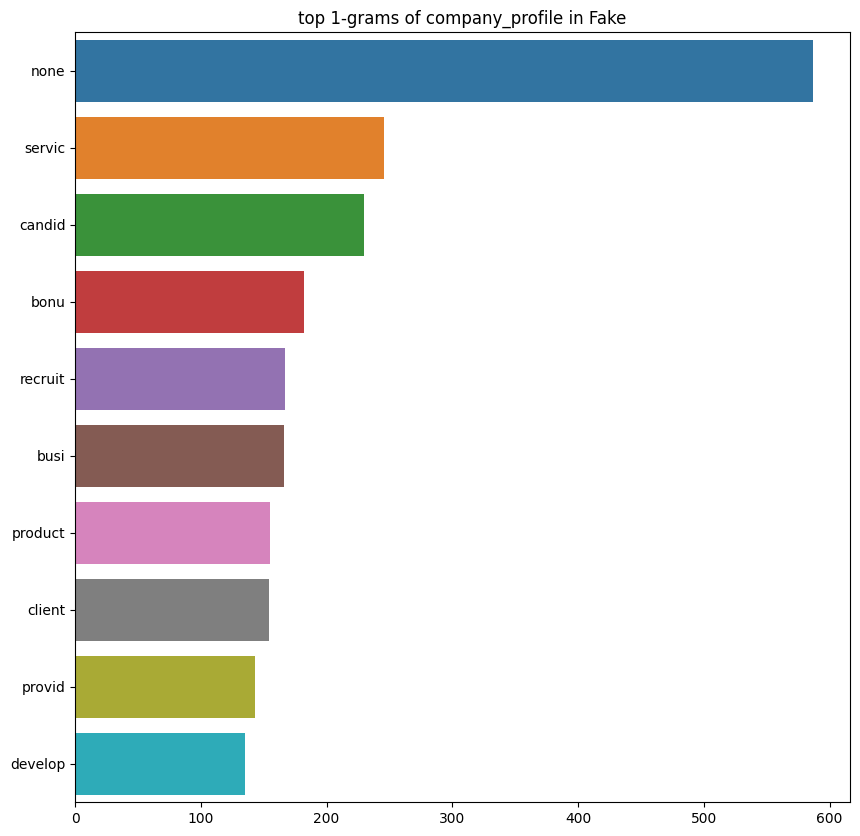

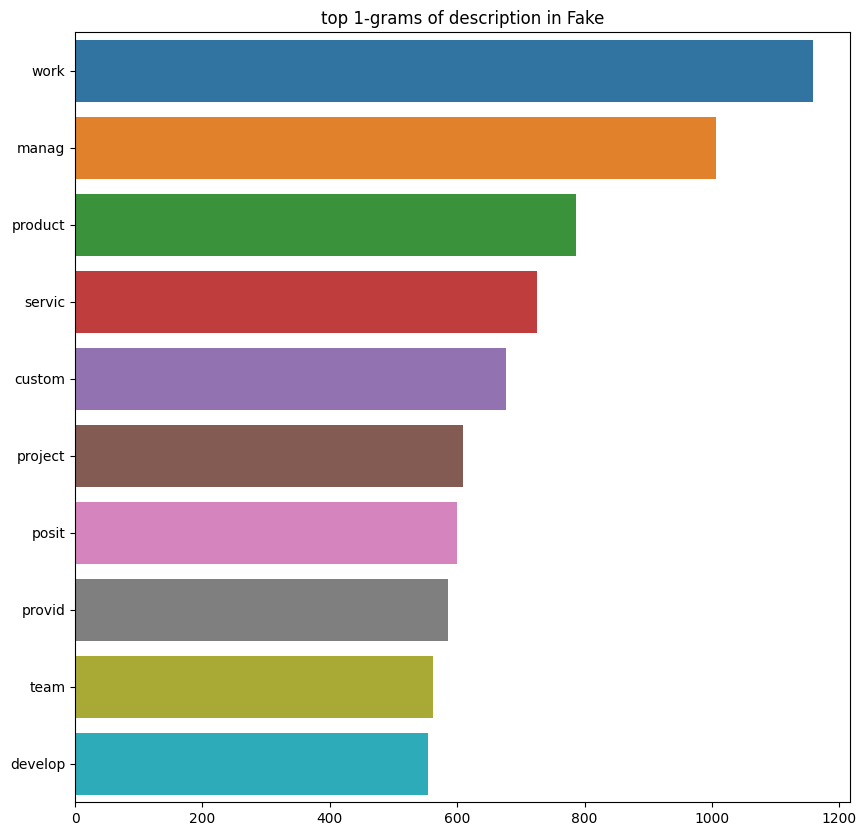

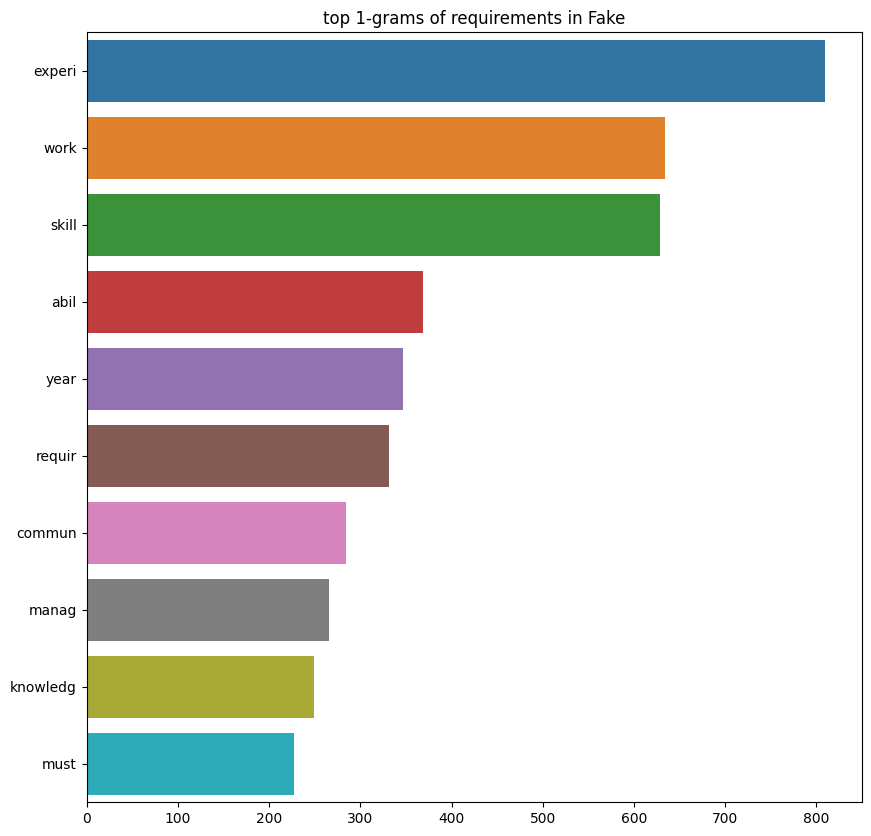

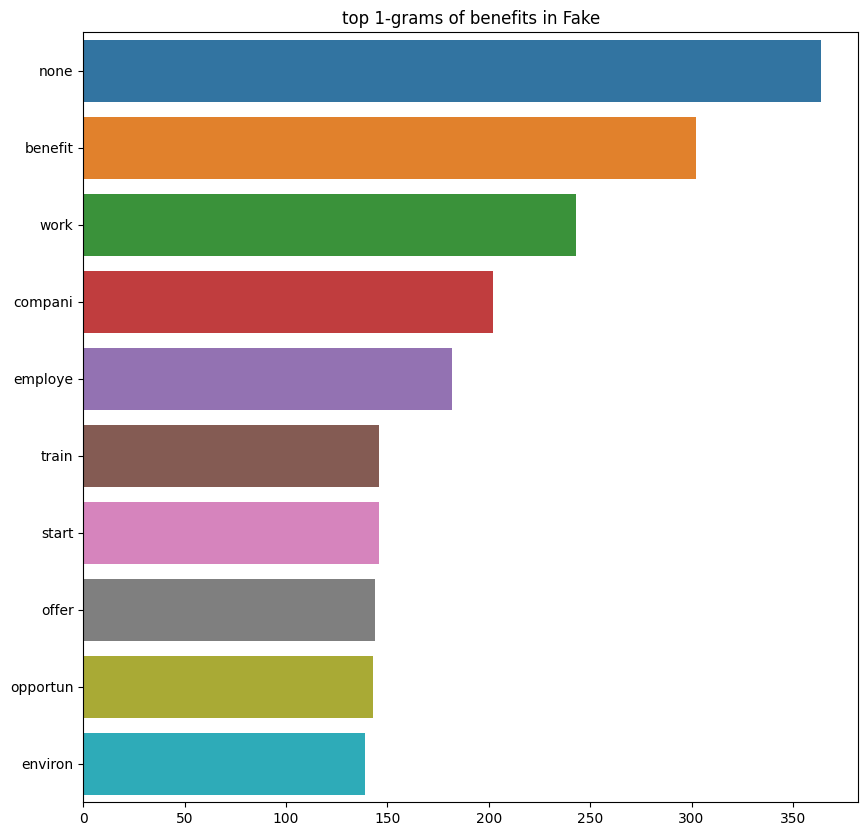

In [37]:
for col in text_df.columns[:-1]:
    plot_top_Ngrams(col, 1, False, n = 10)

In [45]:
# 주소 count 비교

Rcounts = []
for col in textdf.columns[:-1]:
    counts = 0
    for x in textdf[col][textdf.fraudulent == 0]:
        counts += len(re.findall('https?://\S+|www\.\S+', x))
    Rcounts.append(counts)

Fcounts = []
for col in textdf.columns[:-1]:
    counts = 0
    for x in textdf[col][textdf.fraudulent == 1]:
        counts += len(re.findall('https?://\S+|www\.\S+', x))
    Fcounts.append(counts)
    
print(Rcounts)
print(Fcounts)

[0, 180, 74, 1, 29]
[0, 0, 1, 0, 0]


In [67]:
from rake_nltk import Rake

def get_keyword(text, length):
    r = Rake()
    r.extract_keywords_from_text(text)
    full_keyword = r.get_ranked_phrases()
    
    result = []
    for k in full_keyword:
        if len(k.split()) == length:
            result.append(k)
    return result

def keyword_list(col, length, topk, FAKE = True):
    keywords = []
    for x in text_cleaned[col][text_cleaned.fraudulent == FAKE]:
        kw = get_keyword(x, length)[:topk]
        for k in kw:
            keywords.append(k)
    result = pd.DataFrame(keywords)
    return result

def plot_keyword_counts(col, length, topk, plotsize = 10, FAKE = True):
    klist = keyword_list(col, length, topk, FAKE)[0]
    
    fig = plt.figure(figsize = (10, plotsize))
    ax = plt.subplot(1,1,1)
    sns.countplot(y = klist, order = klist.value_counts().iloc[:plotsize].index)
    plt.title('top-{} {} words keywords of {} in {}'.format(topk, length, col, 'Fake' if FAKE else 'Real'))
    plt.show()

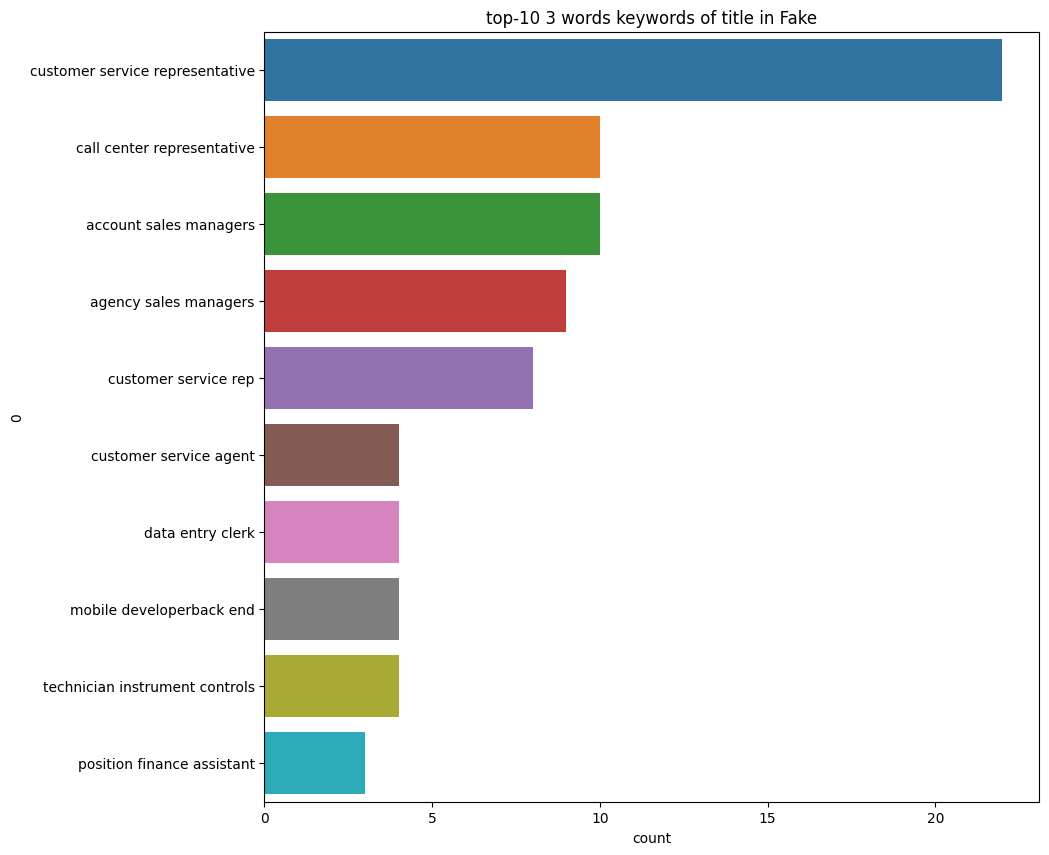

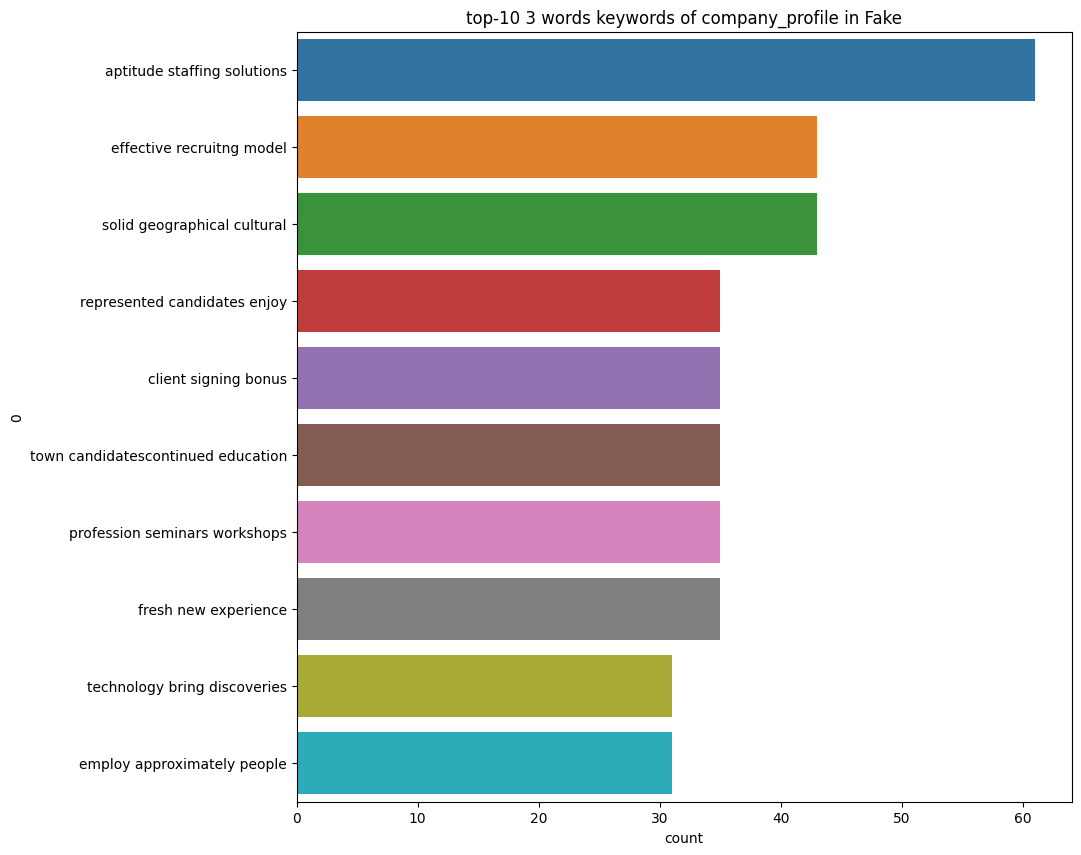

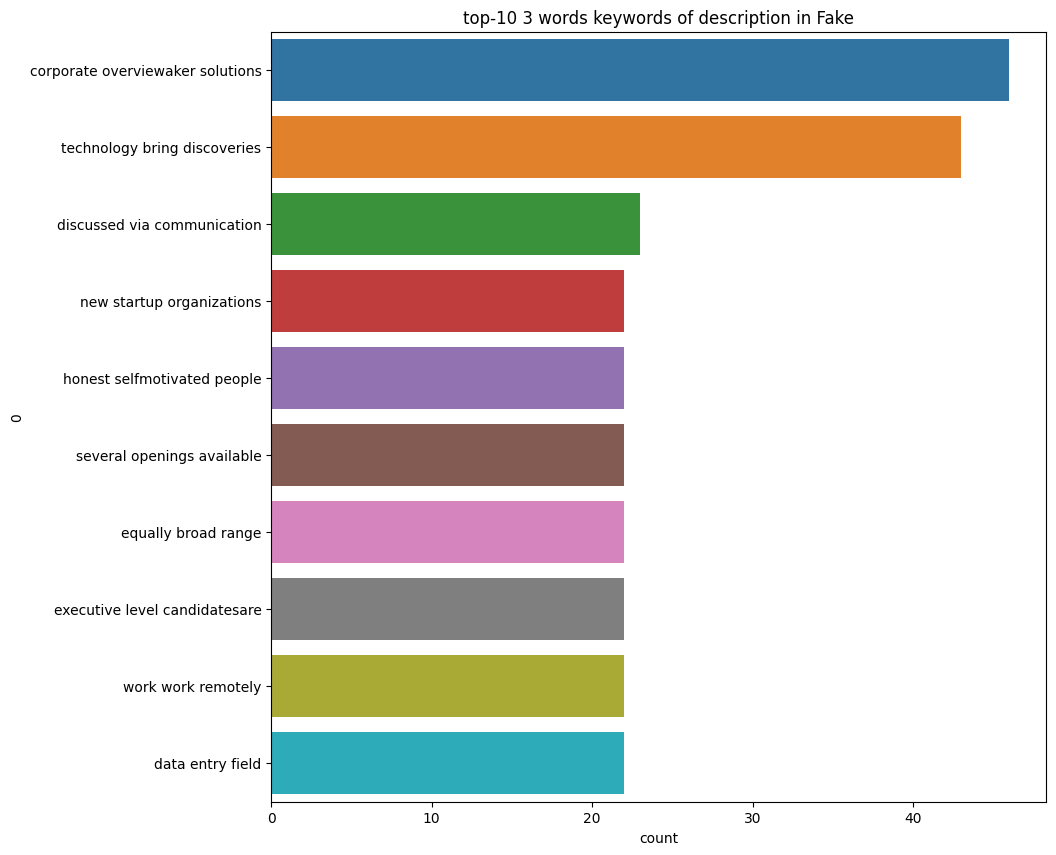

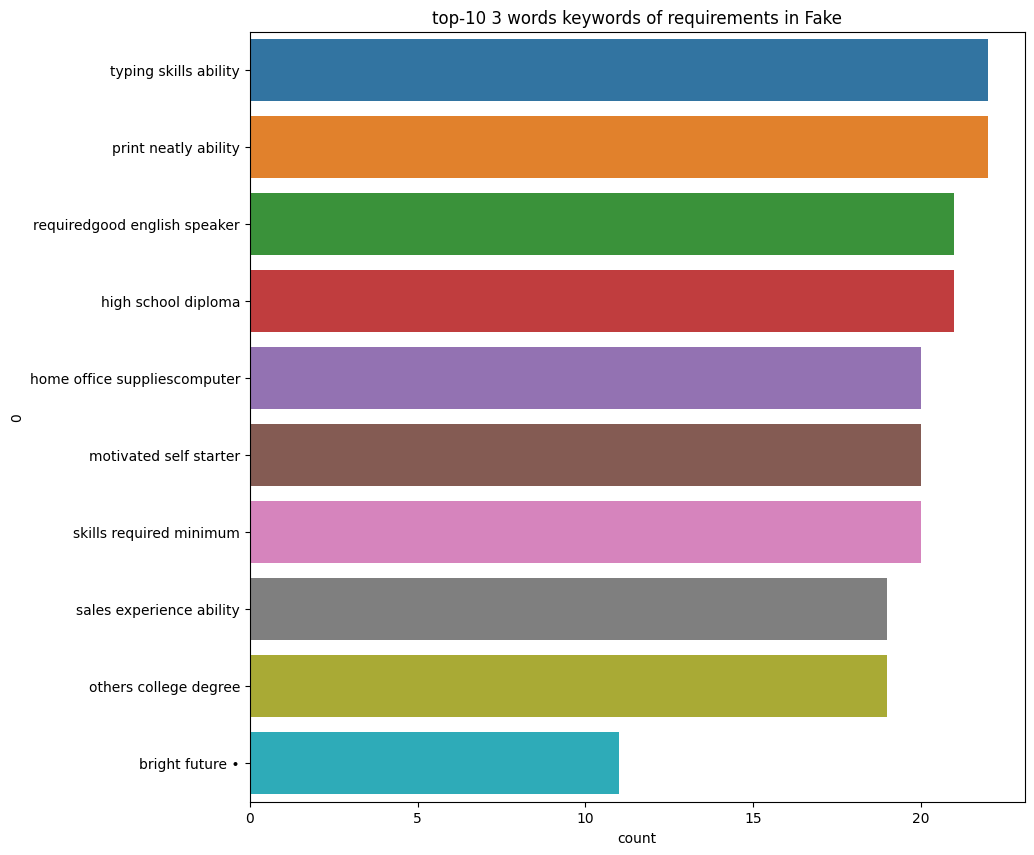

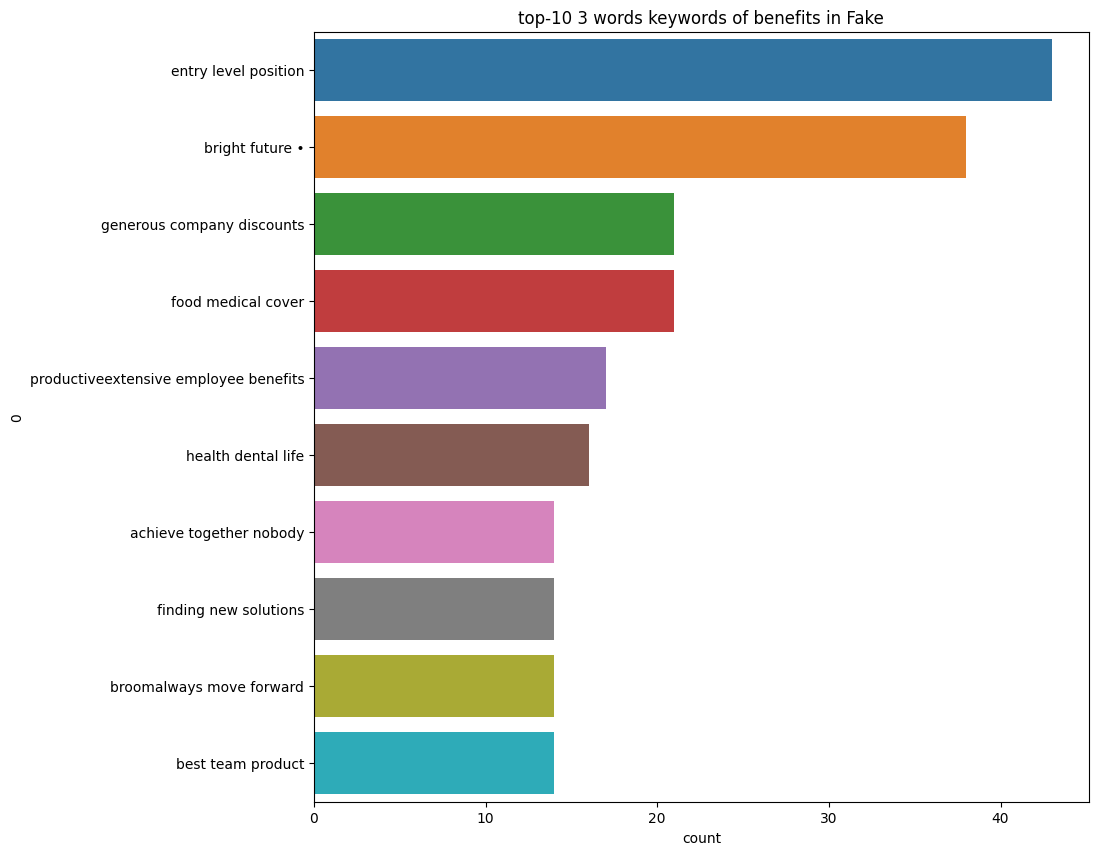

In [126]:
for col in text_cleaned.columns[:-1]:
    plot_keyword_counts(col, 3, 10)

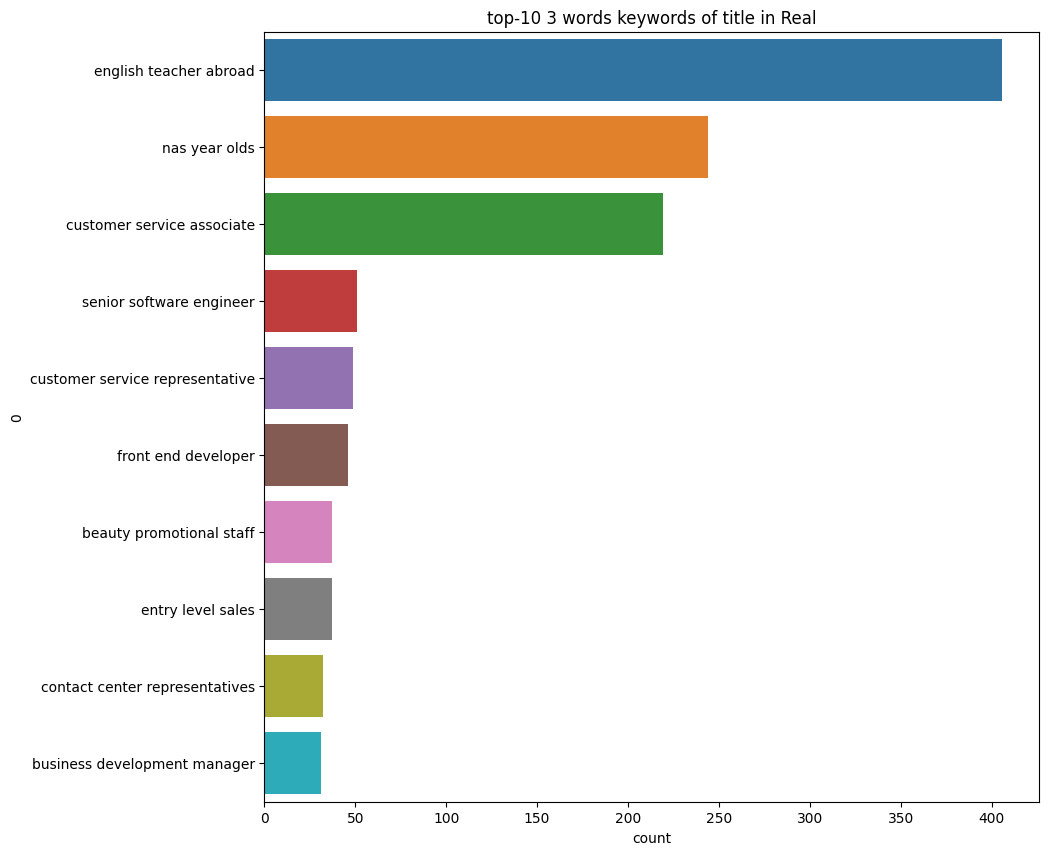

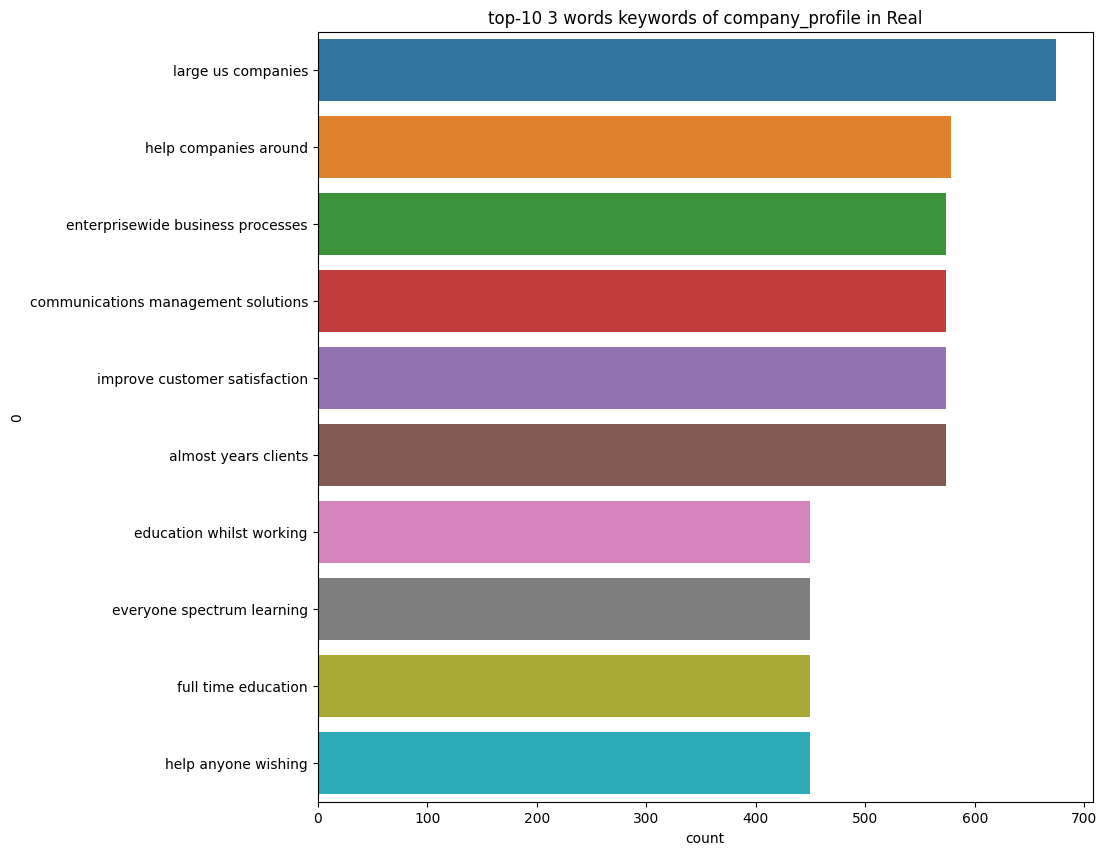

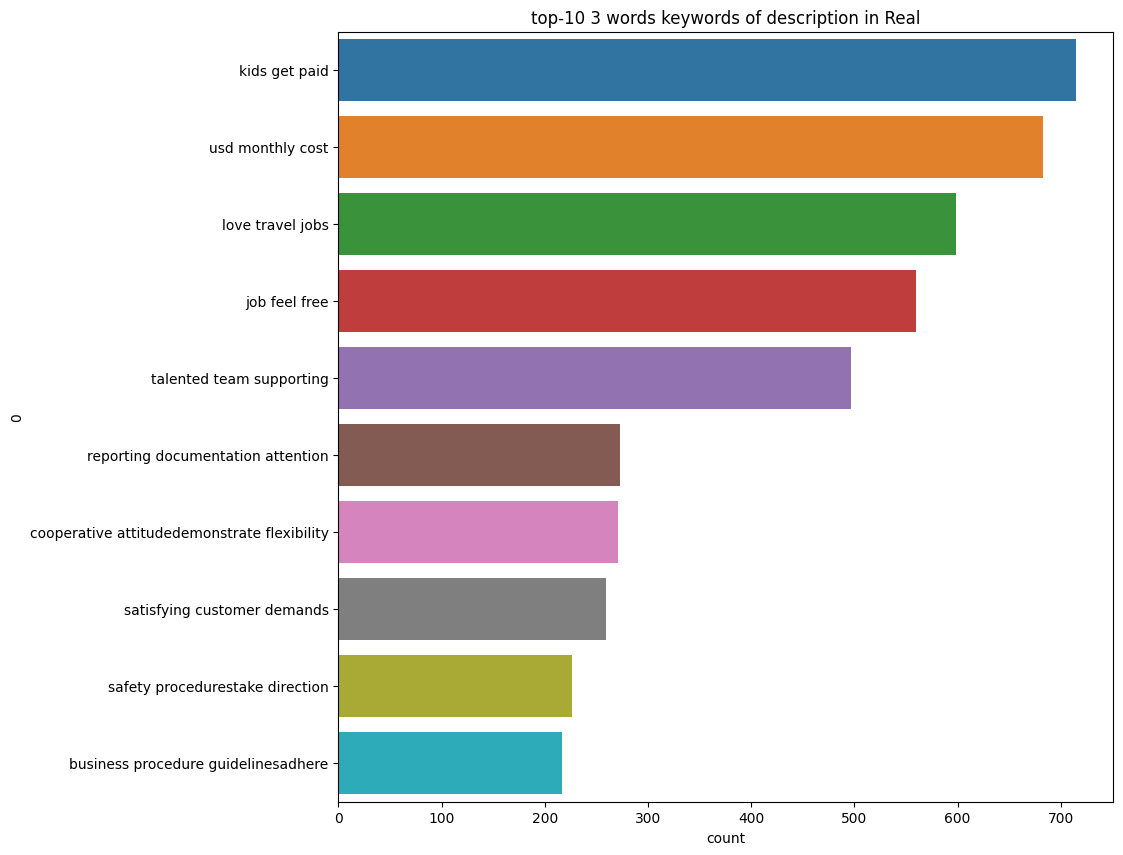

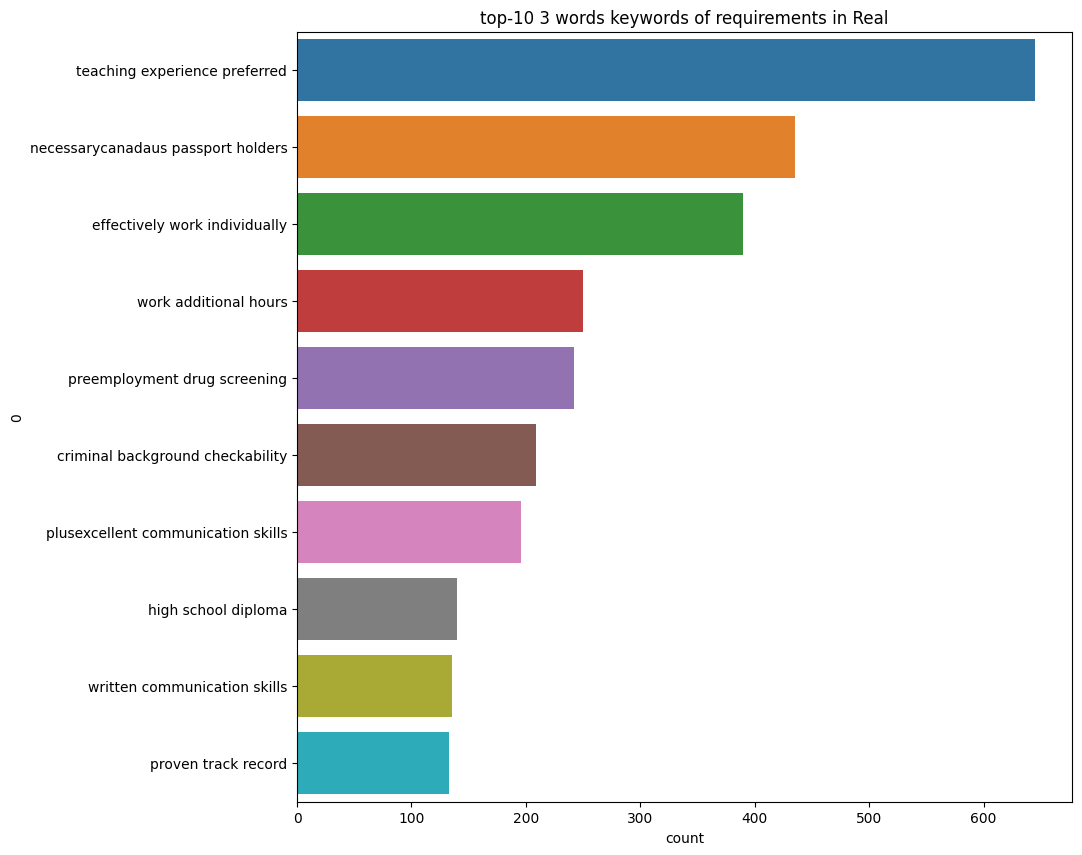

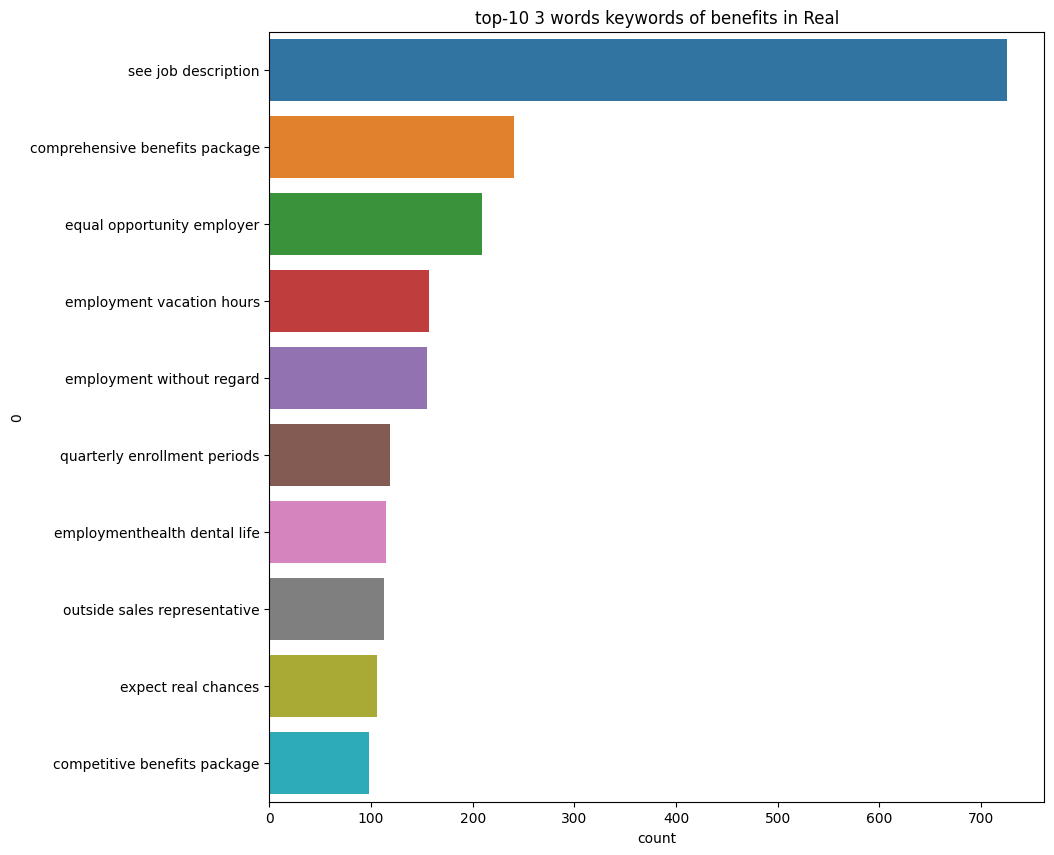

In [128]:
for col in text_cleaned.columns[:-1]:
    plot_keyword_counts(col, 3, 10, FAKE = False)